# Monotone solutions for Hyperbolic equations
In this workbook we are going to use the 1D hyperbolic Grid class from the previous work book and use it to implement a TVD solver. This will provide an oscilation free solution of the linear wave equation, removing the oscilations we observed with the Lax-Wendroff solver.  We are going to use the same test problem too!

So we have a 1m long domain from $x=0.0$ to $x=1.0$ with $C=1.0$.  The initial conditions are

$$u(x,0)=\begin{cases}
\sin^42\pi x &0\le x < \frac12\\
1 & \frac46\le x <\frac56\\
0 & otherwise.\end{cases}$$

and we have periodic boundary conditions at $x=0.0$ and $x=1.0$.

The analytical solution is that the solution should match the 
Let's set it up

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import time

def one(t):
    '''simple function of x and t which allways returns 1.0
    This function is used as a place keeper for the 
    Dirichlet boundary condition.'''
    return 1.0

class Grid:
    '''Class defining the grid for a 1D hyperbolic solver.  Solving
    
    $$\frac{\partial u}{\partial t}=C\left(\frac{\partial u}{\partial x}\right)$$
    
    with periodic boundary conditions.

    The grid object contains the number of grid points (Ni), left
    and right ordinates (x0 and x1) and functions for
    plotting the solution both at a particular time level and in the
    form of an x-t plot.  
    
    The grid also contains the solution vector (u) which is stored as 
    an array with differnt time levels, together with the number of time 
    steps N_t and the (uniform) time step Delta_t.
    
    Becuase the boundary conditions are periodic we will use the roll function
    in the solvers to get the function values at i+1 and i-1.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
       
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we performed
        self.Delta_t = 0.0 # no dt value yet
        self.C = 1.0 # advection speed (Celarity)

        # initialse x,y and u arrays (with ghost cells)
        self.u = np.zeros((1,ni))
        self.x = np.zeros(ni)
        self.t = np.zeros(1)

    def set_x0(self,x0):
        self.x0 = x0
    
    def set_x1(self,x1):
        self.x1 = x1
        
    def set_advection_speed(c):
        self.C = c
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        x0 to the x1.  We are going to do this using linspace from
        numpy to create a list of x ordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        
        if not Quiet:
            print(self)
            print('x =',self.x)

    def initial_conditions(self,fun):
        '''set the initial conditions by calling the specified function
        fun(x) at every ordinate'''
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])
        
        self.t = np.append(self.t, 0.0)
        self.u = np.vstack([self.u, self.u[-1]])
        self.N_t += 1


    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def set_Delta_t(self,Coutrant_number):
        # set the time step using the Courant-Friedirchs-Lewey condition
        self.Delta_t = Coutrant_number * self.Delta_x()/(abs(self.C))
                
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop.  Provided the more
        than 10 timesteps are calculated the results will be
        stored at 10 intermediate times.'''
        
        time = self.t[-1]
        o_time = (t_stop-time)/20 # time for intermediate outputs
        
        # output to the user
        print('Integrating from {:.3g} to {:.3g} seconds Δt={:.3g} :'
              .format(time, t_stop,self.Delta_t),end='')
        
        # time loop
        while True:
            # short time step at the end
            dt = min(self.Delta_t,t_stop-time)
            
            # update the time and save the time and results
            time += dt
            self.u[-1] = solver(self)
            self.t[-1] = time

            # progress monitor
            if (time >= o_time) & (time<t_stop):
                print('#',end='')
                o_time += t_stop/10
                self.t = np.append(self.t, time)
                self.u = np.vstack([self.u, self.u[-1]])
                self.N_t += 1
 
            # are we done
            if time >= t_stop:
                print('. ')
                break
        
    def plot(self,title):
        '''plot the solution at the current time level.  If there are
        more than 60 points in the x-direction then a line is used.'''
        plt.plot(self.x,self.u[self.N_t],'.b')
        plt.plot(self.x,self.u[0],'-k')
        plt.title(title+', t={:.3f}'.format(self.t[-1]))
        plt.show()
        
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Hyperbolic linear advection, C={:.3g}\n'.format(self.C)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        describe += 'Boundaries conditions are - Periodic\n'
        if self.N_t==0:
            describe += 'Initial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t)
        else:
            describe += '{} steps from t=0.0 to t={:.3g}, Δt={:.3g} seconds'.format(self.N_t+1,self.N_t*self.Delta_t,self.Delta_t)
        return describe

In [246]:
def u_init(x):
    ''' Function to set the initial conditions for the test.
    x is a real number
    we return u(x)'''
    
    if x<0.5:
        u0 = np.sin(2*np.pi*x)**4
    elif x>=0.66667 and x<=0.83333:
        u0 = 1.0
    else:
        u0 = 0.0
    return u0



## Lax-Wendroff Scheme

Peter Lax and Burton Wendroff designed a scheme based on using 2nd
order central difference approximations for both $\delta_x$ and
$\delta_{xx}$, i.e.

$$\delta_x.u_i^n=\frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}\mbox{ and }
\delta_{xx}.u_i^n=\frac{c_{i+1}^n-2u_i^n+u_{i-1}^n}{\Delta x^2}.$$ 

These choices lead to the so-called \textcolor{red}{Lax-Wendroff} scheme,

$$
u_i^{n+1}=u_i^n-\frac{C\Delta t}{2\Delta x}\left(u_{i+1}^n-u_{i-1}^n\right)
+\frac{C^2\Delta t^2}{2\Delta x^2}\left(u_{i+1}^n-2u_i^n+u_{i-1}^n\right),
$$

## MacCormack Scheme

The MacCormack scheme is a predictor-corrector (two step) version of the Lax-Wendroff scheme.  Although there is no real difference when computing linear advection problems, the scheme is a little easier to implement on curvilinear grids and for systems of equations.

The predictor simply uses the fist order upwind method

$$\widetilde{u^{n+1}_i}=u^n_i-\frac{C\Delta t}{\Delta x}\left(u^n_i-u^n_{i-1}\right)$$

The corrector updates the predicted values to give the 2nd order solution

$$u^{n+1}_i=\frac{\widetilde{u^{n+1}_i}+u^n_i}{2}-\frac{C\Delta t}{2\Delta x}
\left(\widetilde{u^n_{i+1}}-\widetilde{u^n_i}\right)$$

We'll implement it and compare the solutions.

Integrating from 0 to 2 seconds Δt=0.0095 :##########. 


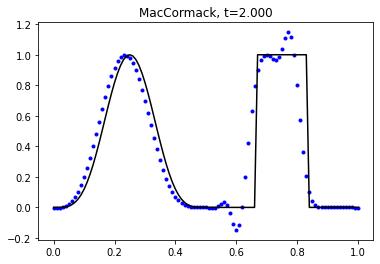

Integrating from 0 to 2 seconds Δt=0.0095 :##########. 
Lax-Wendroff and MacCormack results are identical


In [247]:
def Lax_Wendroff(grid):
    '''perform one time step using the Lax-Wendroff scheme on the 
    hyperbolic  problem defined by grid. We are using whole array 
    opperations for speed.'''
    Rx = grid.C*grid.Delta_t/(2*grid.Delta_x())
    Rx2 = grid.C**2*grid.Delta_t**2/(2*grid.Delta_x()**2)
    
    # get the current solution and the plus and minus values.
    u = grid.u[-1].copy()
    u_plus = np.roll(u,-1)
    u_minus = np.roll(u,1)
    
    u= u - Rx * (u_plus - u_minus) + Rx2 * (u_minus - 2*u + u_plus)
    return u

def MacCormack(grid):
    '''perform one time step using the MacCormack predictor-corrector
    scheme on the hyperbolic problem defined by the grid object. We
    are using whole array opperations for speed.'''
    
    # calculate the coeficients 
    Rx_p = grid.C*grid.Delta_t/(grid.Delta_x())
    Rx_c = grid.C*grid.Delta_t/(2*grid.Delta_x())

    # get the current solution and the plus and minus values.
    u = grid.u[-1].copy()
    u_minus = np.roll(u,1)
    
    # calculate the predictor
    u_pred =  u - Rx_p*(u-u_minus)
    u_pred_plus = np.roll(u_pred,-1)

    # calcuate the corrector
    u = (u + u_pred)/2 - Rx_c * (u_pred_plus - u_pred)
    return u

# MacCormack
test1 = Grid(101)
test1.generate()
test1.set_Delta_t(0.95)
test1.initial_conditions(u_init)

# Let's do two seconds
test1.integrate(2.0, MacCormack)
test1.plot('MacCormack')

# Lax-Wendroff
test2 = Grid(101)
test2.generate()
test2.set_Delta_t(0.95)
test2.initial_conditions(u_init)

# Let's do two seconds
test2.integrate(2.0, Lax_Wendroff)

# Are they the same?  Remember this test will fail unless ALL of the
# isclose() comparisons are true.
try:
    assert np.isclose(test1.u[-1],test2.u[-1]).all
    print("Lax-Wendroff and MacCormack results are identical")
except:
    print("Lax-Wendroff and MacCormack results are different")

## The TVD Scheme
We implement the TVD scheme in the following way:

1. Compute the unmodified 2nd order solution, $u_{Mac}$
2. Calculate the Courant number, $\nu=C\Delta t/\Delta x.$
3. Calculate the upwind and downwind gradients, $\Delta u^+_i=u^n_{i+1}-u^n_i$ and $\Delta u^-_i=u^n_i-u^n_{i-1}$.
4. Calculate $r^+=R(\Delta u^+,\Delta u^-)$ and $r^-=R(\Delta u^-,\Delta u^+)$, where $R(a,b)=(a+\epsilon)/(b+\epsilon).$
5. Compute the gradient functions 

$$G^\pm=\frac{C(\nu)}{2}\left(1-\Phi(r^\pm)\right)$$
where

$$C(\nu)=\begin{cases}
\nu(1-\nu) & \nu<0.5 \cr
0.25 & \text{otherwise}
\end{cases}$$

6. Now we compute the TVD correction

$$TVD_i=(G^+_i+G^-_{i+1})\Delta c^+_i - (G^+_{i-1}+G^-_{i})\Delta c^-_i$$

7. and finally update the solution
$$u^{n+1}=u^{n+1}_{Mac}+TVD\]




In [248]:
def Phi(r):
    '''This function defines the TVD limiter function.
    We are going to use the k limiter. When k=2 this
    is the Super-B limited, when k=1 this is the minmod
    limiter.  k must be in the range [1,2].
    
    $$\Phi(r)=\max(0,\min(kr,1),\min(r,k)$$
    '''
    
    k = 2.0
    limited = r.copy()
    for i in range(limited.shape[0]):
        limited[i] = max(0, min( k*r[i], 1.0), min(r[i], k))

    return limited

def R(a,b):
    '''This is the gradient ratio function, this needs
    a small number to avoid division by zero so we will
    use 1e-5'''
    
    eps = 1.0e-5
    return (a+eps)/(b+eps)

def C(nu):
    '''Courant number function
    
    $$C(\nu)=\begin{cases}
        \nu(1-\nu) & \nu>0.5 \cr
        0.25 & \text{otherwise}
    \end{cases}$$'''
    
    if nu>0.5:
        c = nu*(1-nu)
    else:
        c = 0.25
    return c

def TVD_MacCormack(grid):
    '''Perform one time step of the TVD version of the
    MacCormack scheme for the solution of the linear
    hyperbolic advection equation.  The TVD scheme uses
    the Davis forumulation.'''
    
    # extract the u values
    u = grid.u[-1]
    
    # compute the Courant number
    nu = grid.C*grid.Delta_t/grid.Delta_x()
    C_nu=C(nu)

    # compute gradients, using the roll function to ensure the periodic boundary
    du_plus = np.roll(u,-1) - u
    du_minus = np.roll(du_plus,1)

    # calculate r_plus and r_minus
    r_plus = R(du_minus, du_plus)
    r_minus = R(du_plus, du_minus)
    
    # calculate the slope limited gradient function G
    g_plus = 1 - Phi(r_plus)
    g_minus = 1 - Phi(r_minus) 

    # finally compute the TVD correction
    tvd = C_nu / 2 * (
        (g_plus + np.roll(g_minus,-1)) * du_plus -
        (np.roll(g_plus,1) + g_minus) * du_minus)

    # return the corrected solution
    return  MacCormack(grid) + tvd
    

Integrating from 0 to 2 seconds Δt=0.0095 :##########. 


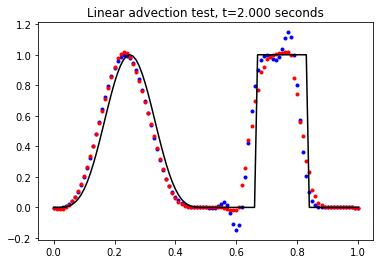

In [253]:
#step function
def step(x):
    if x >= 0.333 and x <= 0.667 :
        u0 = 1.0
    else:
        u0 = 0.0
    return u0

# TVD MacCormack
test3 = Grid(101)
test3.generate()
test3.set_Delta_t(0.95)
test3.initial_conditions(u_init)

# Let's do two seconds
test3.integrate(2.0, TVD_MacCormack)

# compare the results
plt.plot(test1.x,test1.u[test1.N_t],'.b')
plt.plot(test3.x,test3.u[test1.N_t],'.r')
plt.plot(test1.x,test1.u[0],'-k')
plt.title('Linear advection test, t={:0.3f} seconds'.format(test3.t[-1]))
plt.show()



### Analysis
We can see that the TVD scheme